In [18]:
import numpy as np
import scipy as sp
import scipy.ndimage.filters as filters
from scipy.interpolate import interp1d as spline
from sklearn.linear_model import HuberRegressor as hreg
from matplotlib import pyplot as plt
import MAPInference as mapinf
import matplotlib.gridspec as gridspec

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Approximating Bayesian inference in a network model with Hebbian learning and winner take all dynamics

# add reminder of notation!

Recall from the main text and MAP_Estimation_Demo.ipynb that the population remapping appears to approximate *Maximum a Posteriori* ($MAP$) inference of the stimulus given the prior experience of the animal. 
(We also mentioned that in a model that included dynamics, a similar result would likely come from the population sampling from the posterior)



For the Rare Morph condition, that $MAP$ estimation looked like the following

C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'MAP Estimate')

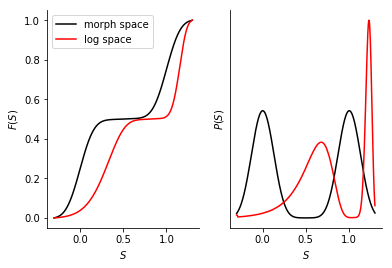

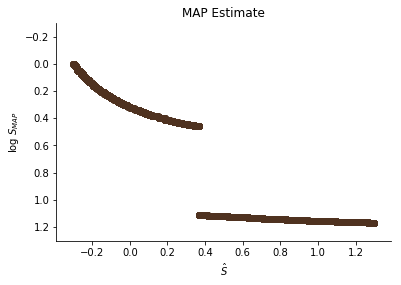

In [19]:
S_hat = np.linspace(-.3,1.3,num=1E4)
rare_prior,rare_log_prior,rare_sampling_spline,f = mapinf.rare_prior(plot=True) # plot prior
rare_map = mapinf.get_MAP(rare_log_prior,S_hat) # get MAP estimate
f,ax = plt.subplots()
ax.scatter(S_hat,rare_map,color=plt.cm.copper(.25))
ax.set_ylim([1.3,-.3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("log $S_{MAP}$")
ax.set_xlabel("$\hat{S}$")
ax.set_title("MAP Estimate")


and for the Frequent Morph condition, MAP estimation looked like ... 

Text(0.5, 1.0, 'MAP Estimate')

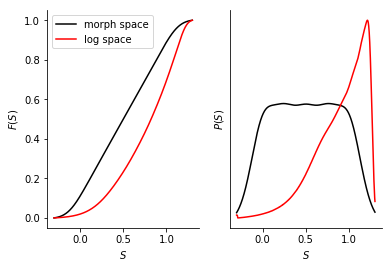

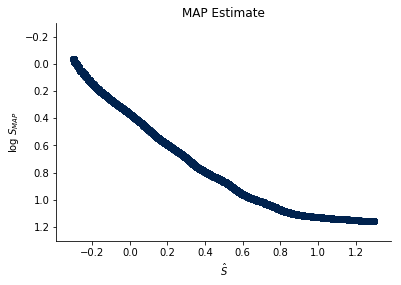

In [20]:
freq_prior, freq_log_prior,freq_sampling_spline,f = mapinf.freq_prior(plot=True)
freq_map = mapinf.get_MAP(freq_log_prior,S_hat)
f,ax = plt.subplots()
ax.set_ylim([1.3,-.3])
ax.scatter(S_hat,freq_map,color=plt.cm.cividis(0.))
ax.set_ylim([1.3,-.3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("log $S_{MAP}$")
ax.set_xlabel("$\hat{S}$")
ax.set_title("MAP Estimate")

This result provides a simple yet powerful normative framework for making predictions about the extent the CA1 population will remap under different conditions. However, this framework does not give us much insight about the cellular and circuit level mechanisms underlying this phenomena. In the work below, we develop a toy model that is able to recapitulate this result using physiologically plausible learning rules with few bells and whistles. 

We do not attempt to make any rigorous theoretical arguments about this class of models and their ability to perform statistial inference.
For more a more rigorous analysis of winner-take-all systems that can perform optimal inference see the following papers:
- Nessler B, Pfeiffer, M, Maass W (2009) STDP enables spiking neurons to detect hidden causes of their inputs. *NIPS* https://papers.nips.cc/paper/3744-stdp-enables-spiking-neurons-to-detect-hidden-causes-of-their-inputs.pdf
- Habenschuss S, Puhr H, Maass W (2013) Emergence of optimal decoding of population codes through STDP. *Neural Computation* http://cognet.mit.edu/journal/10.1162/neco_a_00446
- Habenschuss S, Bill J, Nessler B (2012) Homeostatic plasticity in Bayesian spiking netowrks as Expectation Maximization with posterior constraints. *NIPS* https://papers.nips.cc/paper/4593-homeostatic-plasticity-in-bayesian-spiking-networks-as-expectation-maximization-with-posterior-constraints.pdf

### Motivation using single cell model
Consider a single cell that performs Hebbian learning on its inputs. The input neurons, $x_i$ , are each selective for different values of this stimulus. In this case, we'll choose the input neurons' responses as a function of the stimulus as a set of radial basis functions where each neuron has some preferred stimulus. We'll choose the initial weights from these input neurons to the output neuron as random and small. After learning, we'll see that the weights of the inputs, $w_i$, reflect the statistics of the inputs. In particular the vector of weights will approximate the prior distribution for the stimulus. (This is similar to the finding that feedforward Hebbian networks "perform PCA" on their inputs.) 

The output of the cell $y$ is just a weighted sum of its inputs: $y=\alpha\sum_i{w_i x_i(s)} = \alpha w^{T}x(s)$ where $\alpha$ is a constant.
Each $x_j$ has radial basis function tuning to the stimulus, $x_j(s) = exp(\frac{(s-\phi_j)^2}{\sigma^2})$


Weights will be updated according a Hebbian learning rule with forgetting $\Delta w_i = \eta x_i y - \tau $, $\Delta w = \eta xy - \tau $. $\eta$ is the learning rate, and $\tau$ is the forgetting rate. Both values are  typically small. 

We will also require that weights cannot be negative or go beyond some max value, i.e. the weights are bounded $w_j := min \{ max \{w_j + \Delta w_j,0 \},w_{max}\}$

We can further add noise to the inputs and weight updates if we choose. In this case the output of the cell becomes $y=\alpha w^{T}x(s+\epsilon_s) + \epsilon_y $ and the weight update becomes $\Delta w_i = \eta x_i y - \tau + \epsilon_w $, where $\epsilon_s$, $\epsilon_y$, and $\epsilon_w$ are Gaussian noise terms


In [21]:
### EXAMPLE SINGLE CELL HEBBIAN LEARNING

def single_cell_model(log_cumprior_spline,d):
    '''
    implement hebbian learning for a single cell with inputs that are RBFs for some stimulus
    inputs: log_cumprior_spline - numpy univariate spline for sampling from the cumulative prior
            d - dictionary of parameters
    returns: w - weights of learned model
            yy - activity of cell
    '''
    
    ### INITIALIZATIONS
    THETA = np.linspace(-.3,1.3,num=d['nInputs']) 
    if d['alpha'] is None:
        d['alpha']=1/d['nInputs']
        
        
    w = np.random.rand(d['nInputs']) # uniformly distributed random weights
    
   
    samples = log_cumprior_spline(np.random.rand(d['nSamples']))
    ### LEARNING
    
    for i,s in enumerate(samples.tolist()):
        # generate samples from inputs
        x =mapinf.gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) 
        y=np.maximum(d['alpha']*np.dot(w,x) + d['act noise']*np.random.randn(1),0) # rectified activation of cell
        
        # update weights
        dw = d['eta']*x*y - d['tau'] + d['dW noise']*np.random.randn(w.shape[0])
        w+=dw 
        w=np.maximum(np.minimum(w,d['Wmax']),0) # rectify and clamp range of weights
        

    ### SAMPLE FROM LEARNED MODEL
    morph_theta = np.linspace(-.3,1.3,num=1000) # morph values to sample at
    yy = np.zeros(morph_theta.shape) # output 
    for i,s in enumerate(morph_theta.tolist()):
        # inputs
        x =mapinf.gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) 
        
        yy[i]=np.maximum(d['alpha']*np.dot(w,x) + d['act noise']*np.random.randn(1),0) # rectified activation of cell
    
    return w,yy,morph_theta,samples


Text(0.5, 1.0, 'Frequent morph prior')

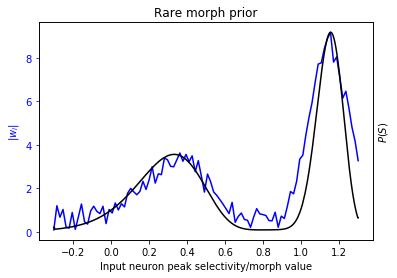

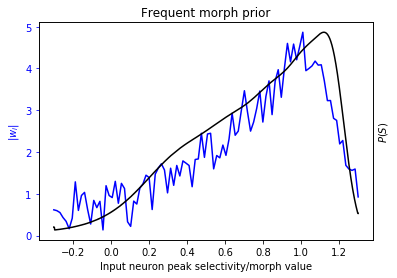

In [22]:
d_singlecell = {'stim noise': .05, # constant for sampling from standard Gaussian noise
    'nInputs': 100, # number of input neurons
    'nSamples':1000, # num training samples
    'alpha':None, # constant to apply to output, defaults to 1/nInputs
    'eta': .1, # learning rate, results are somewhat sensitive to this value
    'sigma': .1, # width of radial basis functions
    'act noise':.0, # noise to apply to output
    'dW noise': 0.005, # constant to apply to weight update noise 
    'tau': .0, # forgetting rate
    'Wmax':100 }

# rare morph prior
w,y,morph_theta,samples = single_cell_model(rare_sampling_spline,d_singlecell)

f,ax = plt.subplots()

ax.plot(np.linspace(-.3,1.3,num=w.shape[0]),w,color='blue')
ax.set_ylabel('$\|w_i\|$')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax_dense = ax.twinx()
ax_dense.plot(np.linspace(-.3,1.3,num=rare_log_prior.shape[0]),rare_log_prior,color='black',label='Prior Density')
ax_dense.set_ylabel('$P(S)$')
ax_dense.set_yticks([])
ax.set_xlabel('Input neuron peak selectivity/morph value')
ax.set_title("Rare morph prior")
# ax_act = ax.twinx()
# ax_act.plot(morph_theta,y)



# frequent morph prior
w,y,morph_theta,samples = single_cell_model(freq_sampling_spline,d_singlecell)

f,ax = plt.subplots()
ax.plot(np.linspace(-.3,1.3,num=w.shape[0]),w,color='blue')
ax.set_ylabel('$\|w_i\|$')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax_dense = ax.twinx()
ax_dense.plot(np.linspace(-.3,1.3,num=freq_log_prior.shape[0]),freq_log_prior,color='black',label='Prior Density')
ax_dense.set_ylabel('$P(S)$')
ax_dense.set_yticks([])
ax.set_xlabel('Input neuron peak selectivity/morph value')
ax.set_title("Frequent morph prior")
# ax_act = ax.twinx()
# ax_act.plot(morph_theta,y)



### Notes on performance and parameter setting: 
Try running this a few times and you will notice some variance in the "goodness" of the approximation of the prior. You can also try messing around with the parameters of the model to see how robust it is. In general it seems that you can either have a slow learning rate and many samples or larger learning rate and fewer samples. Either way if you train for too long, you tend to do poorly. We could alter the model to handle these cases, but we'll favor simplicity and just note the failure modes. In addition, we think the hippocampus may actually be a relatively fast learning system, and we have some evidence (unpublished) that the system stops learning relatively early in experience. Consequently, we'll favor the learn fast with fewer examples approach. Further, it seems that having some noise, particularly in the $\epsilon_s$ term, improves performance.

### Interpretation:
This is a pretty cool result, but also one we should have expected given the known result that Hebbian networks like this will perform PCA on the statistics of their inputs (The latent dimension in this case is just the stimulus prior).

This cell has learned the statistics of its inputs, but the output of this cell is not actually particularly useful quantity for peforming statistical inference. We just showed that the weight vector is approximately the discretized prior, $w \approx P(s) $. By construction, we set up the inputs to be approximately the discretized likelihood of the stimulus, $x(s) \approx P(\hat{s}|s)$. Plugging these approximations into the equation for the activity of the output cell.

$$ y = \alpha\sum_j{w_j x_j(s)} \approx \alpha \int_s P(s)P(\hat{s}|s) \propto P(\hat{s})$$


Thus the cell gives us something like the probability of the sensory estimate regardless of the stimulus. This may be a useful quantity in some contexts, but not for us. HOWEVER! The argument of the integral is actually proportional to the posterior distribution (the thing we actually want in order to perform inference): $ P(s|\hat{s}) \propto P(\hat{s}|s)P(s) $

It feels like we're close. Can we set things up so that we can avoid marginalizing over $s$?


### Moving to a more useful model for inference:

There does not seem to be a way to solve the inference problem for an arbitrary distribution with only one output neuron. Perhaps in a dynamic model you could construct a method, but in this static model with only a scalar activity rate it is not possible. We can likely solve the inference problem with a population of output neurons though. 

One idea of how we could perform inference is to get the activity of a population of neurons to represent the entire posterior distribution (i.e. each neuron represents the posterior probability of some value of the stimulus). If we apply a winner-take-all (WTA) mechanism to this population, we would could approximate *MAP* estimation. If we could get output cells to compete in such a way that they only learn the weights for a vary narrow range of stimulus values the weights for a single output neuron, $\vec{w}_j$, would look something like the following

$$\vec{w}_j \approx \delta(s-\psi_j) \ast P(s) = P(s)\mathbb{1} (s=\psi_j)  $$

where $\psi_j$ is a constant in the range of s. In other words,$\vec{w}_j$ is proportional to a one-hot vector at the value $\psi_j$.

Assuming the inputs are defined the same as the single cell case, before applying WTA to the outputs, each output neuron has the activation 

$$ y_j = \alpha\sum_i{w_{ij} x_i(s)} \approx \alpha \int_s P(\hat{s}|s)P(s)\mathbb{1}(s=\psi_j) = \alpha P(\hat{s}|s=\psi_j)P(s=\psi_j) \propto P(s=\psi_j|\hat{s})$$

The posterior evaluated at a point!!! If we can have $\psi_j$ to tile the range of $s$, it follows that $y$ is approximately proportional to a discretized form of $P(s|\hat{s})$. However, it seems difficult to construct a plausible learning rule in which $\psi_j$ appropriately tile the stimulus and each cell has only 1 $\psi_j$.

In addition, this type of code has several problems. First, it would require that we know which cell codes for which stimulus. The activity of other cells would not provide any information. In more trendy language, the population responses over the range of stimuli would not form a manifold (or the population activity would not be locally differentiable with respect to the stimulus). In the main text, we used analyses that only worked because the population response to the stimulus does form a manifold. Second, the above population code would be a rather brittle--only a small population of cells would represent any given stimulus. 

If instead, we relax the WTA mechanism to a K-WTA (K Winners Take All), the representation of a single stimulus will distribute across a larger number of cells. This will likely solve the two problems above, but we may expand the domain over which any given cell has non-zero weights. The wider the domain with non-zero weights, the closer we get to the unwanted marginalization we saw in the single cell case. Others have shown that these K-WTA models will try to cluster the inputs which would is similar to this idea of representing the prior over a limited domain. 

Let's code it up and see how if our intuitions hold up.


# K-WTA Network Model

Now consider a population of $N$ cells,$\vec{y}$, that performs Hebbian learning on its inputs. 

Inputs to the cells $ \vec{x} = \left( \begin{array}{c} x_1 \\ x_2 \\ \vdots \\ x_j \\ \vdots \\ x_M \end{array} \right) $ are neurons with radial basis function tuning for the stimulus as before
$x_j(s) = exp \left( \frac{(\mu_j -s)^{2}}{\sigma^{2}} \right) $

And the outputs of the cells $\vec{y} = \left( \begin{array}{c} y_1 \\ y_2 \\ \vdots \\ y_i \\ \vdots \\ y_N \end{array} \right) $ are rectified linear functions of their inputs 
$ y_i=  max \{ \alpha z(s+\epsilon_s) \circ KWTA ( z(s+\epsilon_s)+ \epsilon_y ), 0 \} $ where $z(s) = Wx(s+\epsilon_s)$,$W$ is the matrix of weights from input neurons to output neurons, and  $KWTA()$ is the K-WTA function that takes in vector $y$ and outputs a vector of the same size with 1 at the entries that are among the $K$ winners and 0 elserwhere. 

Weights are updated according the same Hebbian learning rule but only the $K$ neurons with the highest activation are allowed to update on each iteration $\Delta w_{ij} = \eta x_j y_i KWTA ( z(s+\epsilon_s)+ \epsilon_y )_i - \tau + \epsilon_w $ . $\eta$ and $\tau$ are again constants

We maintain from the single cell model that weights cannot be negative or go beyond some max value $w_{ij} := min \{ max \{w_{ij} + \Delta w_{ij},0 \},w_{max}\}$, though this is not necessary to get the result.

We will also allow for additive Gaussian noise to the output of the losing neurons at each timestep to prevent things from being exactly orthogonal. 


In [23]:
def kwta_network_model(log_cumprior_spline, d):
    
    ## INITIALIZATIONS
    THETA = np.linspace(-.3,1.3,num=d['nInputs']) 
    if d['alpha'] is None:
        d['alpha']=1/d['nInputs']
    W = .1*np.random.rand(d['nInputs'],d['n_neurons']) # weight matrix
    k = int(d['n_neurons']*d['wta_k']) # number of winners
    
    
    #draw samples for learning
    samples = log_cumprior_spline(np.random.rand(d['nSamples']))
    
    
    ## LEARNING
    for i,s in enumerate(samples.tolist()):
        # inputs
        x =mapinf.gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) 
        # activation of each cell
        act = np.matmul(W.T,x)+ d['act noise']*np.random.randn(d['n_neurons'])
        sort = np.argsort(act) # sort to find K winners
        # determine output for K winners
        Y = np.zeros(act.shape)
        Y[sort[-1:-k-1:-1]]=d['alpha']*act[sort[-1:-k-1:-1]] 
        Y[sort[-k:0:-1]]=d['act noise']*act[sort[-k-1]]*np.random.randn(100-k)
        Y = np.maximum(Y,0) # make sure noise doesn't push the value negative
        
        # update weights
        dw = d['eta']*x[:,np.newaxis]*Y[np.newaxis,:] + d['dW noise']*np.random.randn(W.shape[0],W.shape[1])- d['tau']
        W+=dw
        W=np.maximum(np.minimum(W,d['Wmax']),0)
       

    
    ## SAMPLING
    morph_theta = np.linspace(-.1,1.1,num=1000) # to be closer to what is actually shown in trials
    test_theta = mapinf.morph_2_logstim(morph_theta)
    YY = np.zeros([test_theta.shape[0],d['n_neurons']])
    for i,s in enumerate(test_theta.tolist()):
        # inputs
        x =mapinf.gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) 
        # activation of each cell
        act = np.matmul(W.T,x)+ d['act noise']*np.random.randn(d['n_neurons'])
        sort = np.argsort(act) # sort to find K winners
        # determine output for K winners
        YY[i,sort[-1:-k-1:-1]]=d['alpha']*act[sort[-1:-k-1:-1]]
        YY[i,sort[-k:0:-1]]=d['act noise']*act[sort[-k-1]]*np.random.randn(100-k)
        YY[i,:] = np.maximum(YY[i,:],0)


    ## SIMILARITY RATIO
    centroid0, centroid1 = YY[morph_theta<.05,:].mean(axis=0),YY[morph_theta>.9,:].mean(axis=0)
    centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
    centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
    YY=YY/np.linalg.norm(YY,ord=2,axis=1)[:,np.newaxis]
   
    sr = np.matmul(YY,centroid0[:,np.newaxis])/(np.matmul(YY,centroid0[:,np.newaxis])+np.matmul(YY,centroid1[:,np.newaxis]))
    
    return W,YY,sr



def plot_simmat(S_tm,em,vmax=None,morphcm='cool'):
    '''plot similarity matrices comparing each trial'''

    if vmax is None:
        # vmax=.3
        vmax = np.percentile(S_tm.ravel(),90)
        # vmin=.0
        vmin = np.percentile(S_tm.ravel(),10)


    f = plt.figure(figsize=[5,5])
    gs = gridspec.GridSpec(14,14)

    

    # sort by morph value
    cm_ax = f.add_subplot(gs[:10,:])
    cm_ax.imshow(S_tm,cmap='Greys',vmin=vmin,vmax=vmax,aspect='auto')
    cm_ax.set_yticks([])
    cm_ax.set_xticks([])

    mm_ax = f.add_subplot(gs[10:12,:])
    mm_ax.scatter(np.arange(0,em.shape[0]),em,c=1-em,cmap=morphcm)
    mm_ax.set_xlim([0,em.shape[0]])
 

    return f, [cm_ax,mm_ax]

# Setting model parameters that will be common to both Rare Morph and Frequent morph conditions

In [24]:
# model parameters
d_def= {'stim noise': .05, # constant for sampling from standard Gaussian noise
    'nInputs': 100, # number of input neurons
    'nSamples': 1000, # number of training samples
    'alpha':None, # if None, set to 1/nInputs
    'eta': .1, #.1, # learning rate, results are somewhat sensitive to this value
    'sigma': .15, #.15, # width of radial basis functions
    'act noise': 0.01,#.01, # noise to apply to output
    'dW noise': .05, #.05, # constant to apply to weight update noise 
    'tau': .0,#.00 # forgetting rate
    'n_neurons':100, # number of output neurons
    'wta_k': .3,# proportion of population that are "winners"
    'Wmax': np.inf #10
    }

In [56]:

def loop_model_instances(sampling_spline,d,num=5):
    SS,LAR = [],[]
    THETA = np.linspace(-.3,1.3,num=d['nInputs']) 
    for i in range(num):

        if i%10==0:
            print(i)
        W,YY,lar= kwta_network_model(sampling_spline,d)

        # calculate similarity matrix
        YY_ = YY/np.linalg.norm(YY,2,axis=1)[:,np.newaxis]
        S = np.matmul(YY_,YY_.T)

        # save each models result
        SS.append(S)
        LAR.append(lar)

        if i <6:
            f,ax = plt.subplots()
            trsh=ax.plot(mapinf.logstim_2_morph(THETA),W)
            ax.set_title('Single neuron weights')
            ax.set_xlabel('input peak selectivity')


            f, (s_ax,m_ax) = plot_simmat(S,np.linspace(0,1,num=1000),vmax=None,morphcm='cool')
            s_ax.set_title('Population Similarity Matrix')


            f,ax = plt.subplots()
            ax.scatter(np.linspace(-.3,1.3,num=1000),lar)
            ax.set_title('Similarity Fraction')
            ax.set_xlabel('Morph')
            ax.set_ylabel('SF')

            f,ax = plt.subplots()
            ax.set_title('Neuron weights')
            ax.set_xlabel('Input index')
            ax.set_ylabel('Output index')
            weight_sort = np.argsort(np.argmax(W,axis=0))
            ax.imshow(W[:,weight_sort].T,aspect='auto',cmap='magma')


            f,ax = plt.subplots()
            nrn_sort = np.argsort(np.argmax(YY_,axis=0))
            ax.imshow(YY_[:,nrn_sort],aspect='auto',cmap='magma')
            ax.set_title('Single cell activity over trials')
            ax.set_xlabel('Output neuron index')
            ax.set_ylabel('Trial sorted by morph')
    return np.array(SS), np.array(LAR)


# K-WTA Model for Rare Morph condition

plotting some example runs of the model

0


C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


10
20
30
40


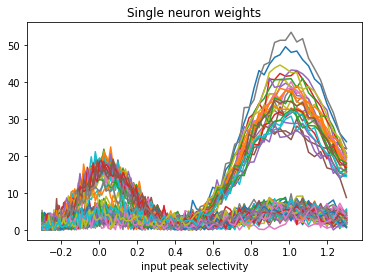

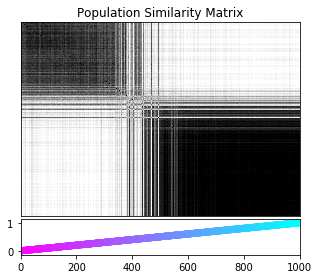

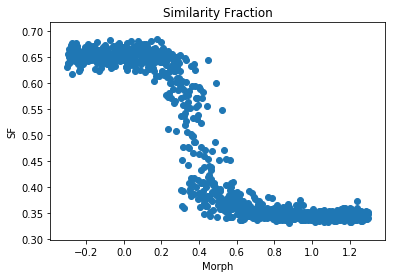

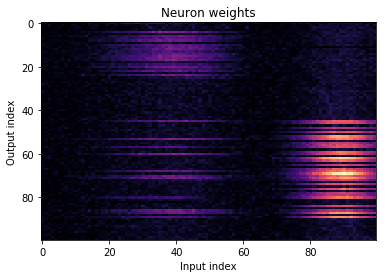

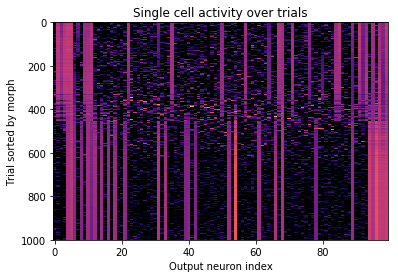

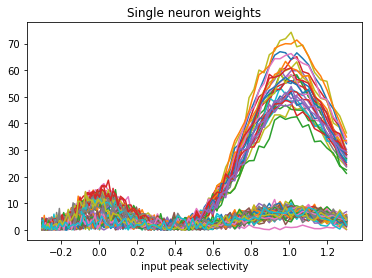

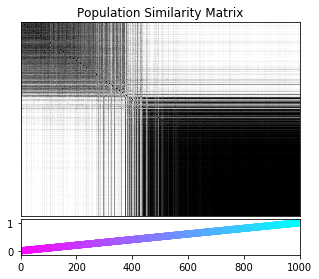

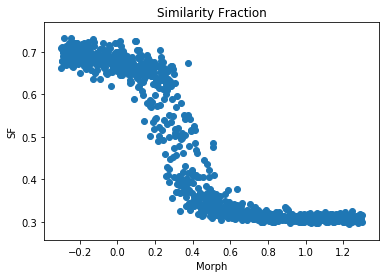

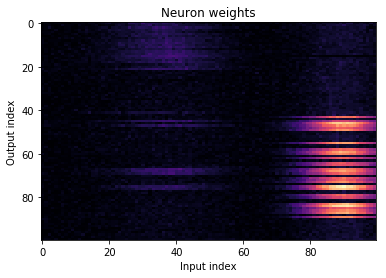

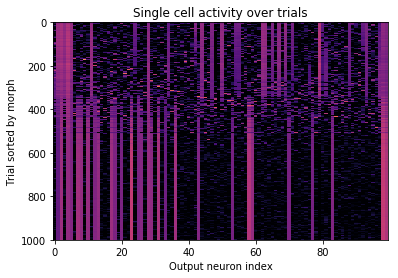

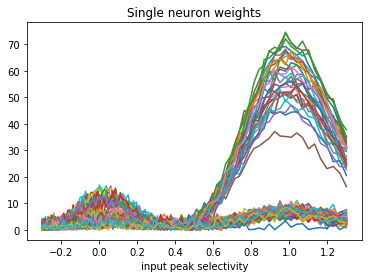

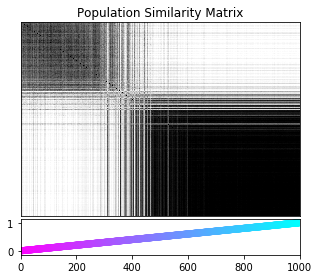

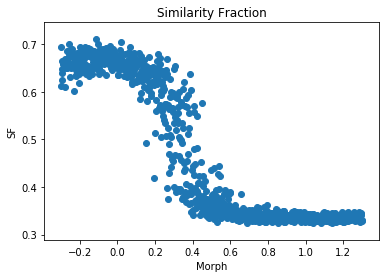

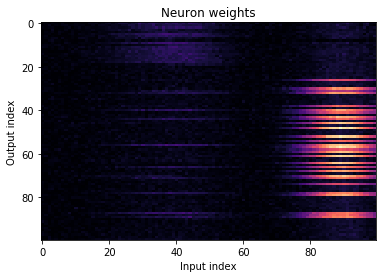

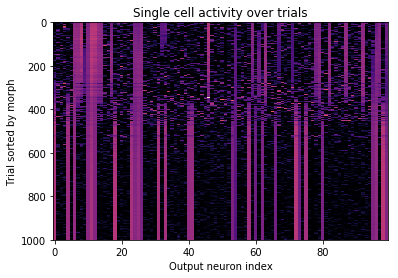

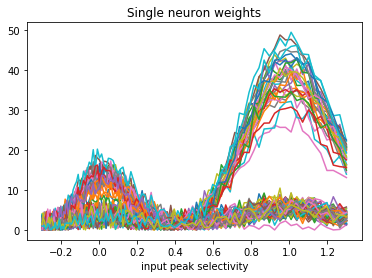

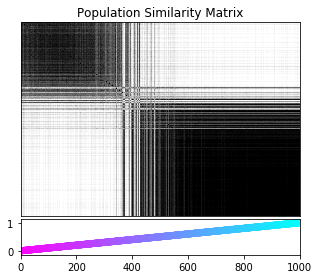

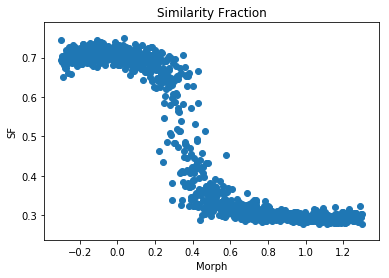

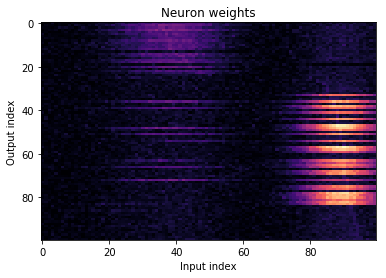

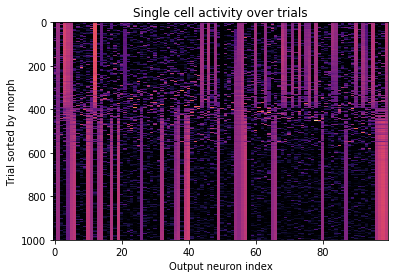

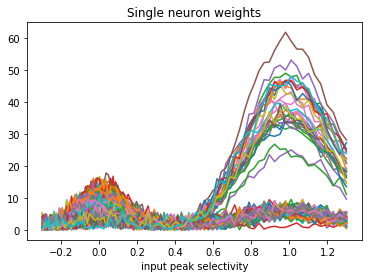

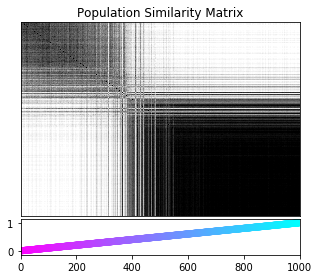

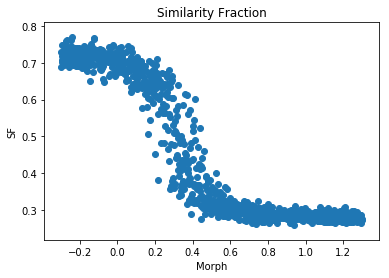

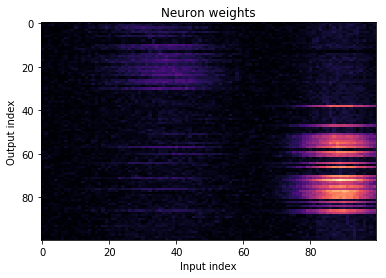

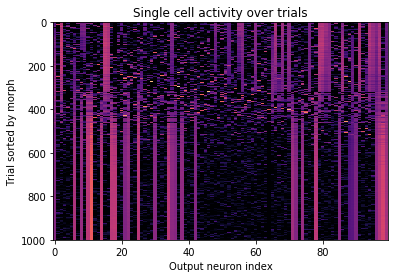

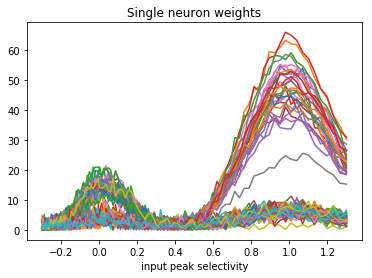

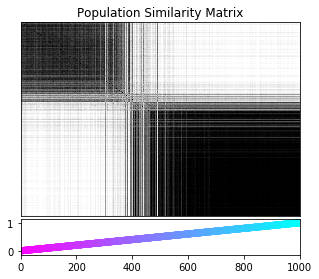

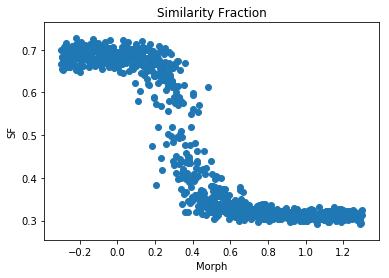

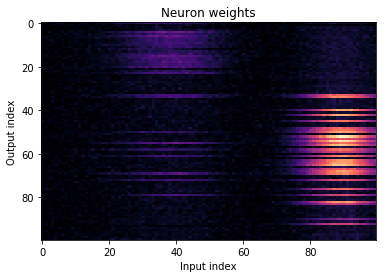

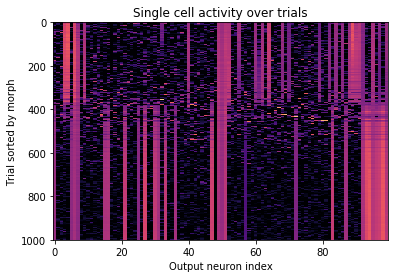

In [57]:
n_models=50
SS_rare,SF_rare = loop_model_instances(rare_sampling_spline,d_def,num=n_models)

# K-WTA Model for Frequent Morph condition

plotting some example runs of the model

0
10
20
30
40


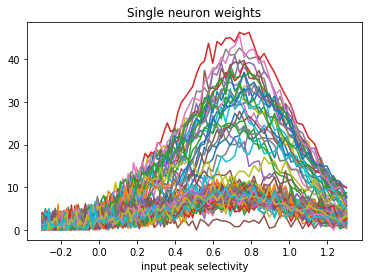

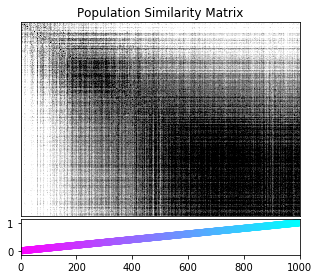

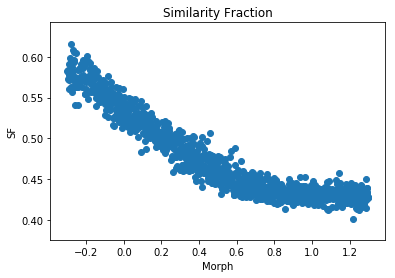

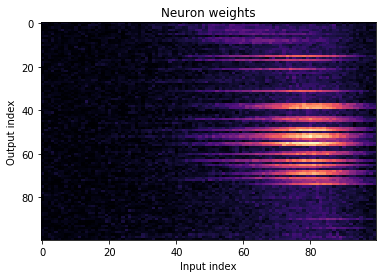

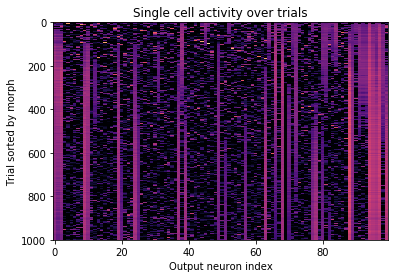

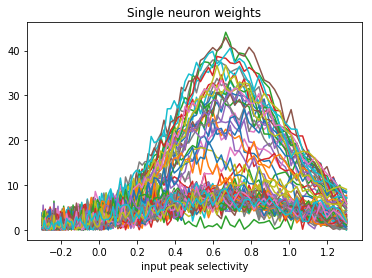

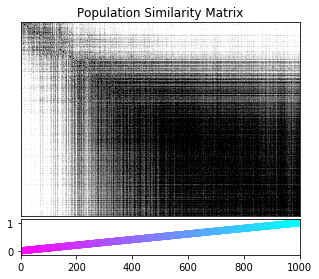

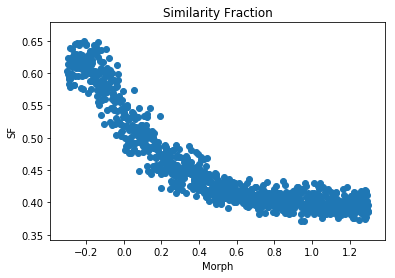

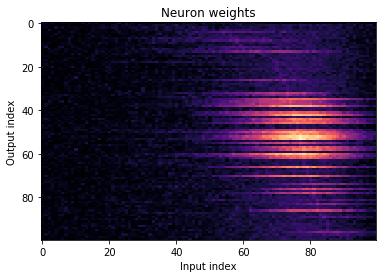

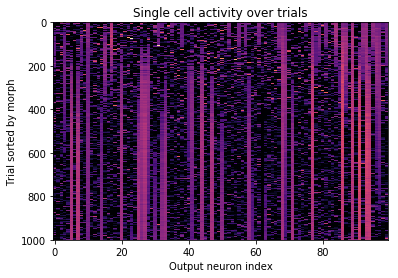

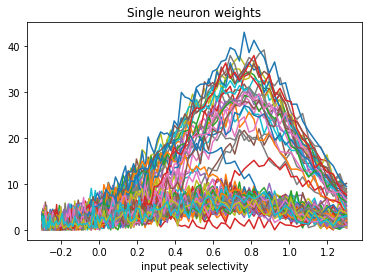

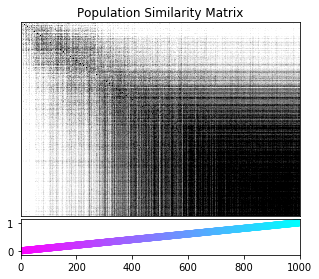

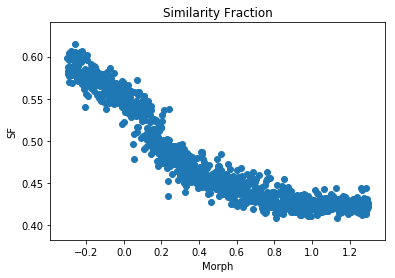

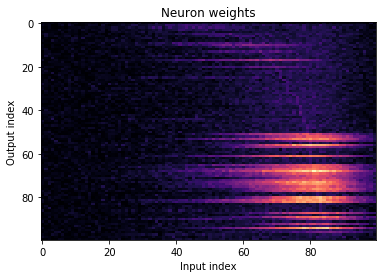

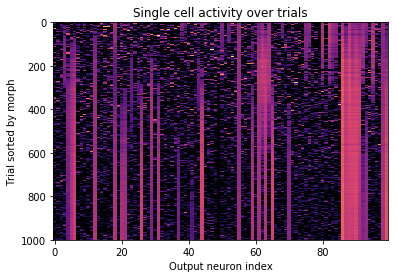

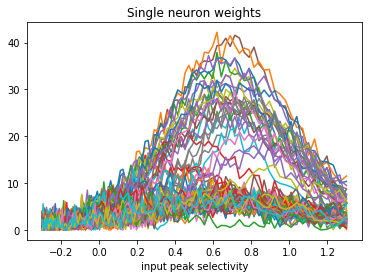

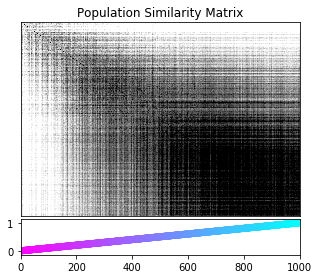

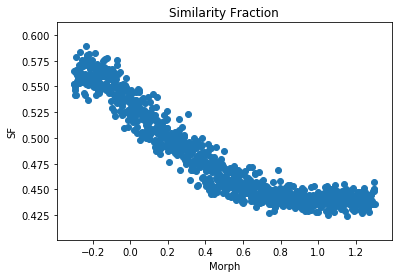

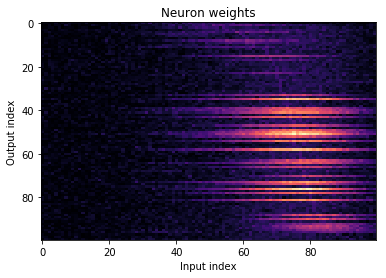

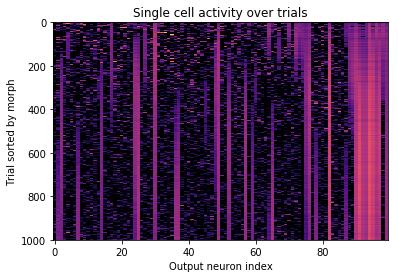

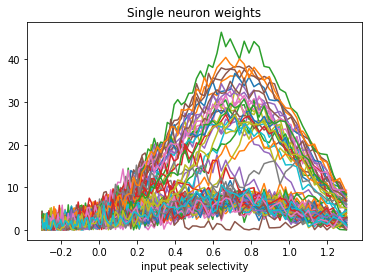

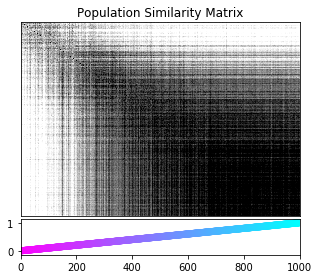

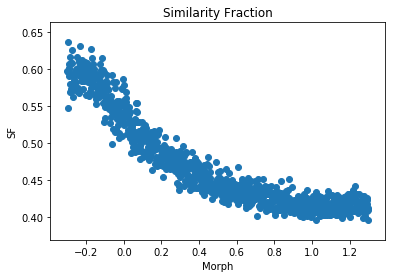

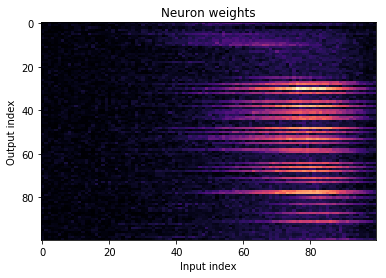

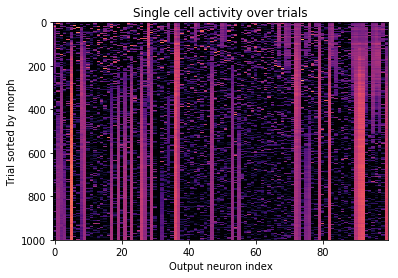

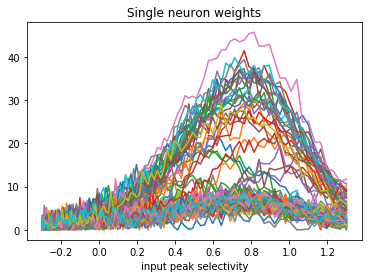

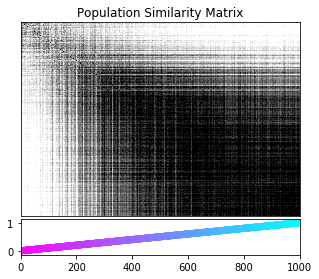

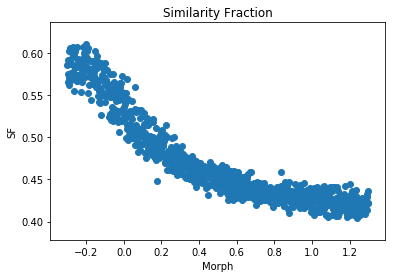

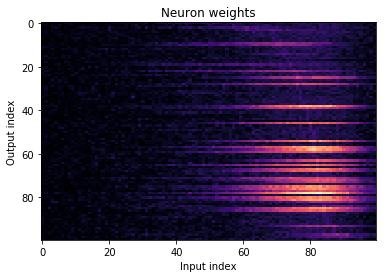

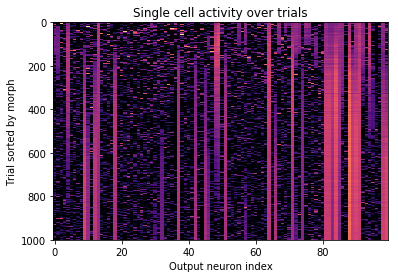

In [58]:
SS_freq,SF_freq = loop_model_instances(freq_sampling_spline,d_def,num=n_models)

## Compute difference between similarity matrices for different conditions

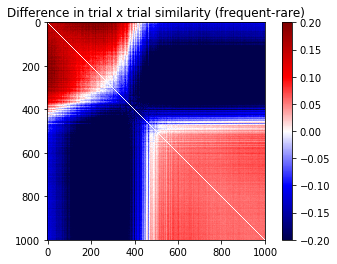

In [59]:
SS_rare_mu = np.array(SS_rare).mean(axis=0)
SS_freq_mu = np.array(SS_freq).mean(axis=0)
SS_dif = SS_rare_mu-SS_freq_mu
f,ax = plt.subplots()
im = ax.imshow(SS_dif,vmin=-.2,vmax=.2,cmap='seismic')
ax.set_title('Difference in trial x trial similarity (frequent-rare)')
f.colorbar(im)


## marginal histogram for log-similarity ratio

(49,)


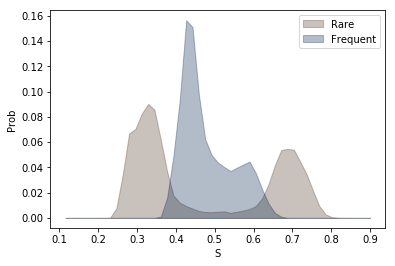

In [60]:
# calculate histograms for log-similarity ratios
bins = np.linspace(0.1,.9)
hist_rare,edges_rare = np.histogram(np.array(SF_rare).ravel(),bins=bins)
print(hist_rare.shape)
hist_rare =hist_rare/hist_rare.sum()
f,ax = plt.subplots()

ax.fill_between(bins[1:],hist_rare,color=plt.cm.copper(.25),label='Rare',alpha=.3)


hist_freq,edges_freq = np.histogram(np.array(SF_freq).ravel(),bins=bins)
hist_freq = hist_freq/hist_freq.sum()
ax.fill_between(bins[1:],hist_freq,color=plt.cm.cividis(0.),alpha=.3,label='Frequent')
ax.set_xlabel('S')
ax.set_ylabel('Prob')
ax.legend()


## Comparing simulations and theory

The above LSR histogram from the simulations and the data remind us a little bit of the plots of the $MAP$ estimate as a function of the stimulus. To make the comparison a bit more clear lets look at the $MAP$ estimate as a function of the stimulus vs the log similarity ratio. We will allow for shift and scaling of the $MAP$ estimate to match the 

In [61]:
x = np.linspace(-.3,1.3,num=1000)
xx = x[np.newaxis,:]*np.ones([n_models,1])
print(SF_rare.shape)

rare_reg = hreg(epsilon=1.01) #linreg()
rare_reg.fit(mapinf.get_MAP(rare_log_prior,xx.reshape([-1,1]))[:,np.newaxis],np.array(SF_rare).reshape([-1,1]))

freq_reg = hreg(epsilon = 1.01) #linreg()
freq_reg.fit(mapinf.get_MAP(freq_log_prior,xx.reshape([-1,1]))[:,np.newaxis],np.array(SF_freq).reshape([-1,1]))


(50, 1000, 1)


C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HuberRegressor(alpha=0.0001, epsilon=1.01, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [63]:
def plot_SF(LAR,x,cmap='copper',ymin=-1.2,ymax=1.2):
    cmap = plt.cm.get_cmap(cmap)
    f = plt.figure()
    gs = gridspec.GridSpec(1,5)
    ax_scat = f.add_subplot(gs[:,:4])
    ax_hist = f.add_subplot(gs[:,-1])
    N = len(LAR)
    bins = np.linspace(ymin,ymax)
    print(N)
    for i,lar in enumerate(LAR):
        z = x.ravel().shape[0]
        inds = np.random.permutation(z)
        inds = inds[:int(.1*z)]
        ax_scat.scatter(x[inds],lar.ravel()[inds],color=cmap(np.float(i/N)),alpha=.4,s=8)
        hist,edges = np.histogram(lar.ravel(),bins=bins)
        ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=cmap(np.float(i/N)),alpha=.4)
    ax_hist.set_ylim([ymin,ymax])
    ax_scat.set_ylim([ymin,ymax])
    ax_hist.set_yticks([])
    return f,(ax_scat,ax_hist)

50


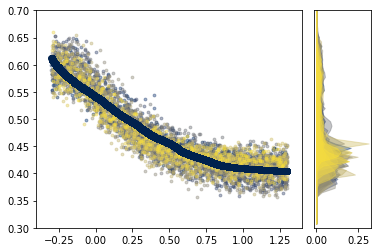

In [64]:
f,ax = plot_SF(SF_freq,x,cmap='cividis',ymin=.3,ymax=.7)
ax[0].scatter(S_hat,freq_reg.coef_*freq_map + freq_reg.intercept_,color=plt.cm.cividis(0.))
# f.savefig(os.path.join(figdir,'fam_sf_map_reg.pdf'))

50


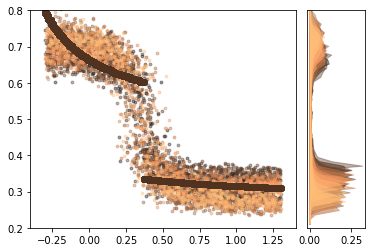

In [65]:
f,ax = plot_SF(SF_rare,x,cmap='copper',ymin=0.2,ymax=.8)
ax[0].scatter(S_hat,rare_reg.coef_*rare_map + rare_reg.intercept_,color=plt.cm.copper(.25))
# f.savefig(os.path.join(figdir,'rare_sf_map_reg.pdf'))